# This demo notebook, is a guide on the simplest way to run Unit Match in python

In [1]:
%load_ext autoreload
%autoreload 

import UnitMatchPy.bayes_functions as bf
import UnitMatchPy.utils as util
import UnitMatchPy.overlord as ov
import numpy as np
import matplotlib.pyplot as plt
import UnitMatchPy.save_utils as su
import UnitMatchPy.GUI as gui
import UnitMatchPy.assign_unique_id as aid
import UnitMatchPy.default_params as default_params

#### Set params and give path to input data (typically a KiloSort directory with the extract RawWaveform folder)

In [2]:
# Get default parameters, can add your own before or after!
param = default_params.get_default_param()

# Give the paths to the KS directories for each session
# If you don't have a dir with channel_positions.npy etc look at the detailed example for supplying paths separately 
KS_dirs = [r'path/to/KSdir/Session1', r'Path/to/KSdir/Session2']

param['KS_dirs'] = KS_dirs
wave_paths, unit_label_paths, channel_pos = util.paths_from_KS(KS_dirs)

Using cluster_group.tsv
Using cluster_group.tsv


#### Run the UnitMatch process
1. Extract parameters from the waveforms e.g Amplitudes, weighted average waveforms and Spatial Decay lengths
2. Calculate metrics/scores for matching e.g Amplitude Score and Waveform similarity
3. Using putative matches find a estimate of drift correction between session (can be done per shank for 2.0 probes)
4. Re-Calculate metrics/scores with the drift corrected metrics
5. Use a naive Bayes classifier to get suggested 'matches' and 'non'matches'
6. (Optional) run the GUI to curated the suggest matches and investigated the UnitMatch results

In [12]:
# STEP 0 -- data preparation
# Read in data and select the good units and exact metadata
waveform, session_id, session_switch, within_session, good_units, param = util.load_good_waveforms(wave_paths, unit_label_paths, param, good_units_only = True) 

# param['peak_loc'] = #may need to set as a value if the peak location is NOT ~ half the spike width

# Create clus_info, contains all unit id/session related info
clus_info = {'good_units' : good_units, 'session_switch' : session_switch, 'session_id' : session_id, 
            'original_ids' : np.concatenate(good_units) }

# STEP 1
# Extract parameters from waveform
extracted_wave_properties = ov.extract_parameters(waveform, channel_pos, clus_info, param)

# STEP 2, 3, 4
# Extract metric scores
total_score, candidate_pairs, scores_to_include, predictors  = ov.extract_metric_scores(extracted_wave_properties, session_switch, within_session, param, niter  = 2)

# STEP 5
# Probability analysis
# Get prior probability of being a match
prior_match = 1 - (param['n_expected_matches'] / param['n_units']**2 ) # freedom of choose in prior prob
priors = np.array((prior_match, 1-prior_match))

# Construct distributions (kernels) for Naive Bayes Classifier
labels = candidate_pairs.astype(int)
cond = np.unique(labels)
score_vector = param['score_vector']
parameter_kernels = np.full((len(score_vector), len(scores_to_include), len(cond)), np.nan)

parameter_kernels = bf.get_parameter_kernels(scores_to_include, labels, cond, param, add_one = 1)

# Get probability of each pair of being a match
probability = bf.apply_naive_bayes(parameter_kernels, priors, predictors, param, cond)

output_prob_matrix = probability[:,1].reshape(param['n_units'],param['n_units'])

c:\Users\Experiment\anaconda3\envs\UnitMatch\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Done drift correction per shank for session pair 1 and 2
Calculating the probability distributions of the metric scores
Calculating the match probabilities


The percentage of units matched to themselves is: 90.69343065693431%
The percentage of false -ve's then is: 9.30656934306569% 

The rate of miss-match(es) per expected match 0.10583941605839416
The percentage of false +ve's is 0.02986780250889541% for session 1
The percentage of false +ve's is 0.04818945339391436% for session 2

This assumes that the spike sorter has made no mistakes


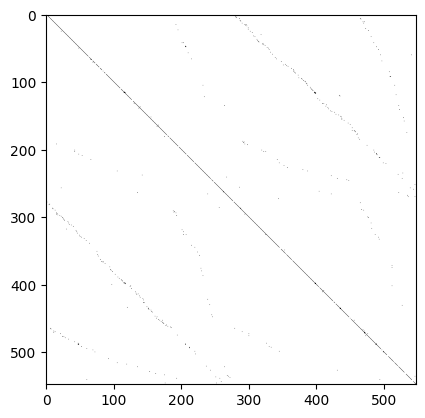

In [4]:
util.evaluate_output(output_prob_matrix, param, within_session, session_switch, match_threshold = 0.75)

match_threshold = param['match_threshold']
# match_threshold = try different values here!

output_threshold = np.zeros_like(output_prob_matrix)
output_threshold[output_prob_matrix > match_threshold] = 1

plt.imshow(output_threshold, cmap = 'Greys')


In [8]:
# STEP 6
# Format data for GUI
amplitude = extracted_wave_properties['amplitude']
spatial_decay = extracted_wave_properties['spatial_decay']
avg_centroid = extracted_wave_properties['avg_centroid']
avg_waveform = extracted_wave_properties['avg_waveform']
avg_waveform_per_tp = extracted_wave_properties['avg_waveform_per_tp']
wave_idx = extracted_wave_properties['good_wave_idxs']
max_site = extracted_wave_properties['max_site']
max_site_mean = extracted_wave_properties['max_site_mean']
gui.process_info_for_GUI(output_prob_matrix, match_threshold, scores_to_include, total_score, amplitude, spatial_decay,
                         avg_centroid, avg_waveform, avg_waveform_per_tp, wave_idx, max_site, max_site_mean, 
                         waveform, within_session, channel_pos, clus_info, param)


In [9]:
# Run GUI
is_match, not_match, matches_GUI = gui.run_GUI()

c:\Users\Experiment\anaconda3\envs\UnitMatch\Lib\site-packages\UnitMatchPy\GUI.py:1267: SyntaxWarning: invalid escape sequence '\m'
  main_ax.set_xlabel('Xpos ($\mu$m)', size = 14)
c:\Users\Experiment\anaconda3\envs\UnitMatch\Lib\site-packages\UnitMatchPy\GUI.py:1268: SyntaxWarning: invalid escape sequence '\m'
  main_ax.set_ylabel('Ypos ($\mu$m)', size = 14)


KeyError: 'original_id'

In [10]:
#this function has 2 mode 'And' 'Or', which returns a matches if they appear in both or one cv pair
#then it will add all the matches selected as IsMaatch, then remove all matches in NotMatch
matches_curated = util.curate_matches(matches_GUI, is_match, not_match, mode = 'And')

NameError: name 'matches_GUI' is not defined

### Add path tp save directory here

In [15]:
matches = np.argwhere(match_threshold == 1)
UIDs = aid.assign_unique_id(output_prob_matrix, param, clus_info)

save_dir = r'Path/to/save/directory'
#NOTE - change to matches to matches_curated if done manual curation with the GUI
su.save_to_output(save_dir, scores_to_include, matches # matches_curated
                  , output_prob_matrix, avg_centroid, avg_waveform, avg_waveform_per_tp, max_site,
                   total_score, output_threshold, clus_info, param, UIDs = UIDs, matches_curated = None, save_match_table = True)

KeyError: 'original_id'